In [5]:
import tensorflow as tf
import os
import glob

IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 32

data_dir = "./data/DUTS-TR/"
image_paths = sorted(glob.glob(os.path.join(data_dir, "DUTS-TR-Image/*.jpg")))
mask_paths = sorted(glob.glob(os.path.join(data_dir, "DUTS-TR-Mask/*.png")))

print(f"Found {len(image_paths)} images and {len(mask_paths)} masks.")

path_ds = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

def load_and_preprocess(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.image.convert_image_dtype(image, tf.float32) # Normalizes to [0,1]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1) # Load as grayscale (tf.uint8)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')

    mask = tf.cast(mask, tf.float32)
    mask = mask / 255.0

    mask = tf.cast(mask > 0.5, dtype=tf.float32)

    return image, mask


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = path_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE) \
    .shuffle(buffer_size=1000) \
    .batch(BATCH_SIZE) \
    .prefetch(buffer_size=AUTOTUNE)

Found 10553 images and 10553 masks.


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def build_unet_model(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

model = build_unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │  2,097,664 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    train_dataset,
    epochs=30
)

print("Training complete!")

Epoch 1/30


2025-10-25 18:07:28.084485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


330/330 ━━━━━━━━━━━━━━━━━━━━ 530s 2s/step - accuracy: 0.7390 - loss: 2.7897 - mean_io_u_1: 0.4001
Epoch 2/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - accuracy: 0.8306 - loss: 0.6441 - mean_io_u_1: 0.3882
Epoch 3/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 525s 2s/step - accuracy: 0.8691 - loss: 0.4453 - mean_io_u_1: 0.3871
Epoch 4/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 542s 2s/step - accuracy: 0.8846 - loss: 0.3803 - mean_io_u_1: 0.3852
Epoch 5/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 555s 2s/step - accuracy: 0.9018 - loss: 0.3060 - mean_io_u_1: 0.3844
Epoch 6/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - accuracy: 0.9108 - loss: 0.2654 - mean_io_u_1: 0.3840
Epoch 7/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 536s 2s/step - accuracy: 0.9197 - loss: 0.2308 - mean_io_u_1: 0.3830
Epoch 8/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 536s 2s/step - accuracy: 0.9269 - loss: 0.2074 - mean_io_u_1: 0.3830
Epoch 9/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - accuracy: 0.9340 - loss: 0.1867 - mean_io_u_1: 0.3826
Epoch 10/30
330/330 ━━━━━━━━━━

In [9]:
model_path = "./models/saliency_unet.keras"

print(f"Saving model to {model_path}...")
model.save(model_path)
print("Model saved successfully!")

Saving model to ./models/saliency_unet.keras...
Model saved successfully!


Found 5019 test images and 5019 test masks.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>
Evaluating model on the test set...
157/157 ━━━━━━━━━━━━━━━━━━━━ 76s 483ms/step - accuracy: 0.9067 - loss: 0.4496 - mean_io_u_1: 0.4410
--- Results ---
Test Loss:     0.5364760756492615
Test Accuracy: 0.8914149403572083
Test MeanIoU:  0.4398173391819
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.44360352..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..252.1604].


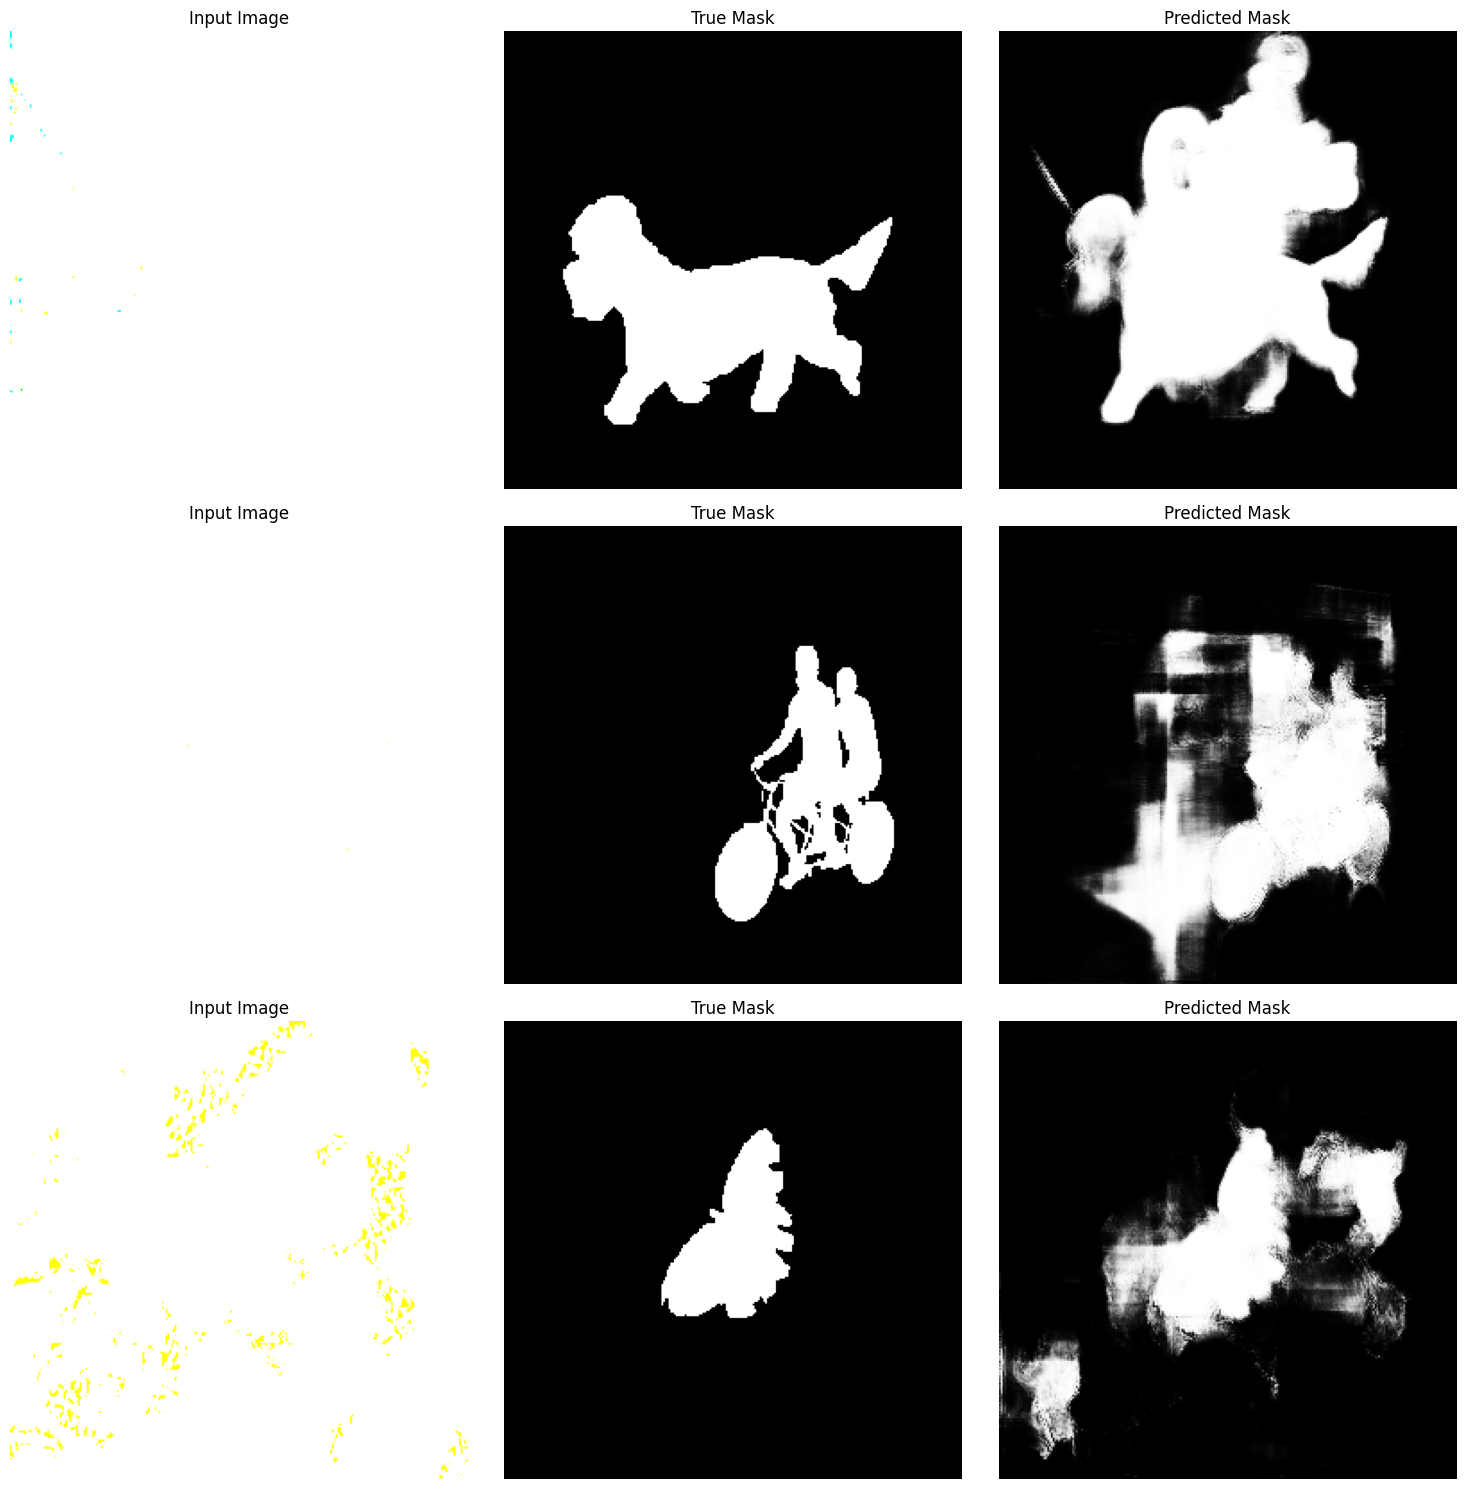

In [14]:
import matplotlib.pyplot as plt

test_data_dir = "./data/DUTS-TE/"

test_image_paths = sorted(glob.glob(os.path.join(test_data_dir, "DUTS-TE-Image/*.jpg")))
test_mask_paths = sorted(glob.glob(os.path.join(test_data_dir, "DUTS-TE-Mask/*.png")))

print(f"Found {len(test_image_paths)} test images and {len(test_mask_paths)} test masks.")

AUTOTUNE = tf.data.AUTOTUNE

test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths)) \
    .map(load_and_preprocess, num_parallel_calls=AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(buffer_size=AUTOTUNE)

print(test_dataset)

print("Evaluating model on the test set...")
results = model.evaluate(test_dataset)

print("--- Results ---")
print(f"Test Loss:     {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test MeanIoU:  {results[2]}")

def display_predictions(dataset, num_to_show=3):
    for image_batch, mask_batch in dataset.take(1):
        predicted_mask_batch = model.predict(image_batch)

        plt.figure(figsize=(15, num_to_show * 5))

        for i in range(num_to_show):
            plt.subplot(num_to_show, 3, i*3 + 1)
            plt.title("Input Image")
            plt.imshow(image_batch[i])
            plt.axis('off')

            plt.subplot(num_to_show, 3, i*3 + 2)
            plt.title("True Mask")
            plt.imshow(mask_batch[i][..., 0], cmap='gray')
            plt.axis('off')

            plt.subplot(num_to_show, 3, i*3 + 3)
            plt.title("Predicted Mask")
            plt.imshow(predicted_mask_batch[i][..., 0], cmap='gray')
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break

display_predictions(test_dataset)